# Convolutional Neural Networks (CNN): The "Spatial" Brain

In our previous ANN, we flattened the image ($8 \times 8 \rightarrow 64$). We destroyed the grid.
This means the model didn't know that pixel (0,0) is next to (0,1).

### The Solution
We treat the input as an **Image** ($1 \times 8 \times 8$).
We scan it with **Filters** (Convolutions) to find patterns.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Load Data (Reshaped for CNN)
digits = load_digits()
X = digits.data
y = digits.target

# Standard Scaling is still good practice
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# CRITICAL STEP: Reshape to (N, Channels, Height, Width)
# Channels = 1 (Grayscale)
X_reshaped = X_scaled.reshape(-1, 1, 8, 8)

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Convert to Tensors
X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train, dtype=torch.long)
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_tensor_train, y_tensor_train)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

print(f"Input Shape: {X_train.shape}") # Should be (N, 1, 8, 8)

Input Shape: (1437, 1, 8, 8)


## Defining the ConvNet
1.  **Conv2d:** Scans the image.
2.  **MaxPool2d:** Shrinks the image (Focuses on the strongest features).
3.  **Flatten:** Prepares for final classification.

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Layer 1: Conv -> ReLU -> Pool
        # Input: 1 x 8 x 8
        # Conv2d(1, 16, 3, padding=1) -> Output: 16 x 8 x 8 (Padding keeps size same)
        # Pool(2) -> Output: 16 x 4 x 4
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully Connected Layer (Classifier)
        # Input to this is 16 channels * 4 * 4 pixels = 256
        self.fc = nn.Linear(16 * 4 * 4, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1) # Flatten: (Batch, 256)
        out = self.fc(out)
        return out

model = SimpleCNN()
print(model)

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=256, out_features=10, bias=True)
)


## Training Loop (Same as before)

Epoch 1, Loss: 1.7988
Epoch 2, Loss: 0.9283
Epoch 3, Loss: 0.5119
Epoch 4, Loss: 0.3478
Epoch 5, Loss: 0.2624
Epoch 6, Loss: 0.2072
Epoch 7, Loss: 0.1698
Epoch 8, Loss: 0.1461
Epoch 9, Loss: 0.1221
Epoch 10, Loss: 0.1076


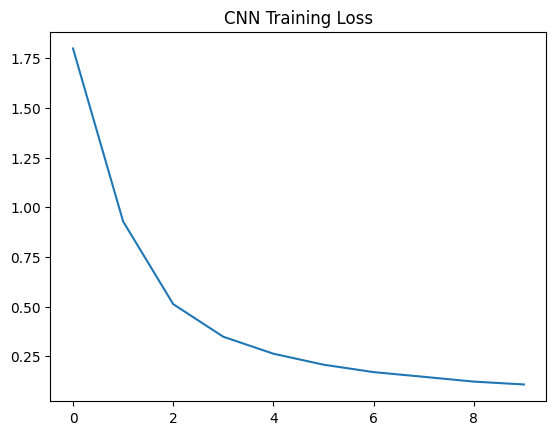

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10 
losses = []

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

plt.plot(losses)
plt.title("CNN Training Loss")
plt.show()

## Evaluation
Does it beat the ANN?

In [4]:
model.eval()
with torch.no_grad():
    outputs = model(X_tensor_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_tensor_test).sum().item() / len(y_tensor_test)
    print(f"CNN Test Accuracy: {accuracy:.4f}")

CNN Test Accuracy: 0.9806


### Inspecting the Filters (What applied math looks like)
We can actually look at the filters the model learned. These are the 3x3 grids it slides over the image.

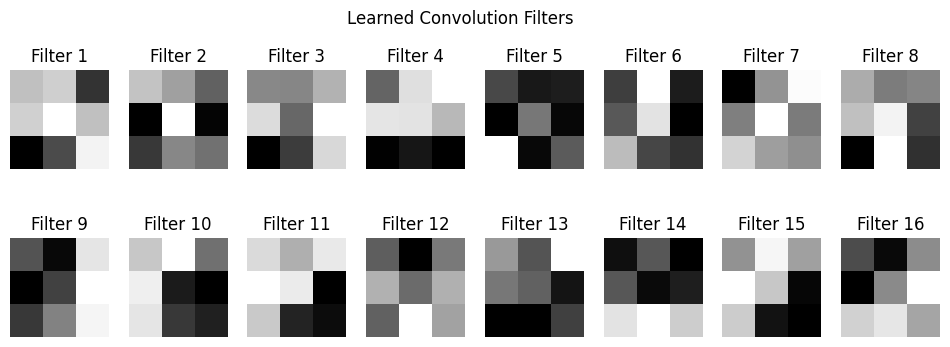

In [5]:
# Get the weights of the first layer
filters = model.layer1[0].weight.data.cpu().numpy()

fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for i, ax in enumerate(axes.flat):
    # Filter shape is (1, 3, 3), we need (3, 3)
    ax.imshow(filters[i, 0, :, :], cmap='gray')
    ax.axis('off')
    ax.set_title(f"Filter {i+1}")
plt.suptitle("Learned Convolution Filters")
plt.show()


---
# Real World CNN: CIFAR-10
---
We now move from the academic dataset to a **Real World Problem**.

# Real World CNN: CIFAR-10 Classification

This is the **"Graduation Exam"** for basic Deep Learning.
Unlike MNIST (Grayscale digits), CIFAR-10 contains **Color Photographs** (32x32 pixels) of 10 real-world objects:
Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.

### Challenges
1.  **Color:** Input is 3 Channels (Red, Green, Blue).
2.  **Complexity:** A cat is harder to define than the number "1".
3.  **Overfitting:** The model will easily memorize the training images. We need **Regularization**.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

Using Device: cpu


## 1. Data Augmentation (The Anti-Cheat)
If we just show the model static images, it keeps memorizing pixels.
We randomly **Flip** and **Shear** images during training so the model never sees the exact same image twice. This forces it to learn *concepts* (e.g., "ears"), not pixels.

In [12]:
# Transforms: Random modifications
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize RGB channels
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download Data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Visualizing the Data

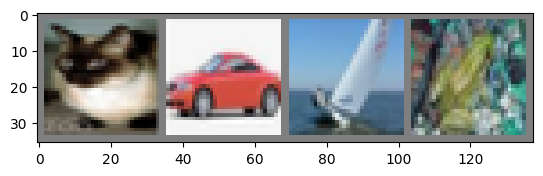

cat   car   ship  frog 


In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## 2. Defining a Robust CNN
We will add:
- **3 Input Channels** (RGB).
- **Dropout:** Randomly turn off neurons to prevent co-dependency.
- **BatchNorm:** Normalize layer outputs to speed up training.

In [14]:
class CIFARNet(nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Block 2
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully Connected (Calculated size: 128 * 8 * 8)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool2(self.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = CIFARNet().to(device)
print(net)

CIFARNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


## 3. Training Loop

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 10 # Increase this for better results (20-50)
history = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(trainloader)
    history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

print('Finished Training')

Epoch 1, Loss: 1.3930
Epoch 2, Loss: 1.0671
Epoch 3, Loss: 0.9341
Epoch 4, Loss: 0.8594
Epoch 5, Loss: 0.8003
Epoch 6, Loss: 0.7504
Epoch 7, Loss: 0.7083
Epoch 8, Loss: 0.6688
Epoch 9, Loss: 0.6354
Epoch 10, Loss: 0.6048
Finished Training


## 4. Evaluation
Random guessing is 10%. A simple ANN gets ~40%. We aim for >70%.

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 76.08 %
